___

# WELCOME!

___

This data originally came from Crowdflower's Data for Everyone library.

As the original source says,

A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

The data we're providing on Kaggle is a slightly reformatted version of the original source. It includes both a CSV file and SQLite database. The code that does these transformations is available on GitHub

For example, it contains whether the sentiment of the tweets in this set was positive, neutral, or negative for six US airlines:

In [322]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Exploratory Data Analysis

### Import Libraries, Load and Discover the Data

In [323]:
# !pip install pyforest
# 1-Import Libraies
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import missingno as msno 

# Scaling
from sklearn.preprocessing import scale 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.compose import make_column_transformer

# Importing plotly and cufflinks in offline mode
import plotly.express as px
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

# Figure&Display options
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('max_colwidth',200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# !pip install termcolor
import colorama
from colorama import Fore, Style  # maakes strings colored
from termcolor import colored

import ipywidgets
from ipywidgets import interact

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from collections import Counter
from wordcloud import WordCloud 


import matplotlib.pyplot as plt
from wordcloud import WordCloud
from termcolor import cprint
import seaborn as sns
import warnings  

### Some Useful User Defined Functions

In [324]:
# To view summary information about the df

def first_looking(df):
    print(colored("Shape:", attrs=['bold']), df.shape,'\n', 
          colored('-'*79, 'red', attrs=['bold']),
          colored("\nInfo:\n", attrs=['bold']), sep='')
    print(df.info(), '\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("Number of Uniques:\n", attrs=['bold']), df.nunique(),'\n',
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("Missing Values:\n", attrs=['bold']), missing_values(df),'\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("All Columns:", attrs=['bold']), list(df.columns),'\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')

    df.columns= df.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')

    print(colored("Columns after rename:", attrs=['bold']), list(df.columns),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')

In [325]:
# To view summary information about the columns

def first_look(col):
    print("column name    : ", col)
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(df[col].isnull().sum()/df.shape[0]*100, 2))
    print("num_of_nulls   : ", df[col].isnull().sum())
    print("num_of_uniques : ", df[col].nunique())
    print(df[col].value_counts(dropna = False))

In [326]:
# To view the missing value information of df

def missing_values(df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values[missing_values['Missing_Number']>0]

### Implement basic steps to see how data looks like!

In [327]:
# df = pd.read_csv("../input/Tweets.csv")

In [328]:
df = pd.read_csv("Tweets.csv")

In [329]:
df.head(1)

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                         1.000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   

  airline_sentiment_gold     name negativereason_gold  retweet_count  \
0                    NaN  cairdin                 NaN              0   

                                  text tweet_coord              tweet_created  \
0  @VirginAmerica What @dhepburn said.         NaN  2015-02-24 11:35:52 -0800   

  tweet_location               user_timezone  
0            NaN  Eastern Time (US & Canada)

In [330]:
df.tail(1)

tweet_id airline_sentiment  airline_sentiment_confidence  \
14639  569587140490866689           neutral                         0.677   

      negativereason  negativereason_confidence   airline  \
14639            NaN                      0.000  American   

      airline_sentiment_gold       name negativereason_gold  retweet_count  \
14639                    NaN  daviddtwu                 NaN              0   

                                                                                                                                             text  \
14639  @AmericanAir we have 8 ppl so we need 2 know how many seats are on the next flight. Plz put us on standby for 4 people on the next flight?   

      tweet_coord              tweet_created tweet_location user_timezone  
14639         NaN  2015-02-22 11:58:51 -0800     dallas, TX           NaN

In [331]:
df.sample(3)

tweet_id airline_sentiment  airline_sentiment_confidence  \
2147  569339072805797888          negative                         1.000   
7120  569929677571166208          negative                         0.650   
4670  569946428547551233          negative                         1.000   

                   negativereason  negativereason_confidence    airline  \
2147  Flight Attendant Complaints                      0.657     United   
7120                   Can't Tell                      0.650      Delta   
4670       Customer Service Issue                      1.000  Southwest   

     airline_sentiment_gold         name negativereason_gold  retweet_count  \
2147                    NaN     D4Duskes                 NaN              0   
7120                    NaN  JohnRHealey                 NaN              0   
4670                    NaN  CoachJEvans                 NaN              0   

                                                                                                                                          text  \
2147        @united who compensates is for the delays caused by the fact that you don't have enough flight attendants?? http://t.co/96apr35qan   
7120                                                                                                                   Do less please @JetBlue   
4670  @SouthwestAir pretty terrible customer service. Sat on hold 10 min. Then a busy signal. Then disconnected. Do all airlines have to suck?   

     tweet_coord              tweet_created tweet_location  \
2147         NaN  2015-02-21 19:33:07 -0800       Montreal   
7120         NaN  2015-02-23 10:39:58 -0800        DMV/CLE   
4670         NaN  2015-02-23 11:46:32 -0800       Missouri   

                   user_timezone  
2147  Eastern Time (US & Canada)  
7120  Eastern Time (US & Canada)  
4670  Eastern Time (US & Canada)

In [332]:
first_looking(df)

Shape:(14640, 15)
-------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord   

- The dataset has 15 columns and 14640 observations.
- We have 2 int64 type, 2 float64 type and 11 object type column in the dataset.
- Columns "negativereason_gold", "airline_sentiment_gold" and "tweet_coord" will be dropped as they contain more than 90% missing values.

In [333]:
df.describe()

tweet_id  airline_sentiment_confidence  \
count              14640.000                     14640.000   
mean  569218351767382528.000                         0.900   
std      779111158481836.750                         0.163   
min   567588278875213824.000                         0.335   
25%   568559178101439488.000                         0.692   
50%   569477857923110912.000                         1.000   
75%   569890473289000960.000                         1.000   
max   570310600460525568.000                         1.000   

       negativereason_confidence  retweet_count  
count                  10522.000      14640.000  
mean                       0.638          0.083  
std                        0.330          0.746  
min                        0.000          0.000  
25%                        0.361          0.000  
50%                        0.671          0.000  
75%                        1.000          0.000  
max                        1.000         44.000

In [334]:
df.describe(include=object).T

count unique                         top  freq
airline_sentiment       14640      3                    negative  9178
negativereason           9178     10      Customer Service Issue  2910
airline                 14640      6                      United  3822
airline_sentiment_gold     40      3                    negative    32
name                    14640   7701                 JetBlueNews    63
negativereason_gold        32     13      Customer Service Issue    12
text                    14640  14427              @united thanks     6
tweet_coord              1019    832                  [0.0, 0.0]   164
tweet_created           14640  14247   2015-02-24 09:54:34 -0800     5
tweet_location           9907   3081                  Boston, MA   157
user_timezone            9820     85  Eastern Time (US & Canada)  3744

**Detect and drop duplicated observations**

In [335]:
print("There are", df.duplicated(subset=None, keep='first').sum(), "duplicated observations in the dataset.")
print(df.duplicated(subset=None, keep='first').sum(), "Duplicated observations were dropped!")
df.drop_duplicates(keep='first', inplace=True)

There are 36 duplicated observations in the dataset.
36 Duplicated observations were dropped!


**Check for missing values**

In [336]:
df.isnull().sum().sort_values(ascending=False)

negativereason_gold             14572
airline_sentiment_gold          14564
tweet_coord                     13589
negativereason                   5445
user_timezone                    4814
tweet_location                   4723
negativereason_confidence        4101
tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
airline                             0
name                                0
retweet_count                       0
text                                0
tweet_created                       0
dtype: int64

In [337]:
df.isnull().melt(value_name="missing")

variable  missing
0            tweet_id    False
1            tweet_id    False
2            tweet_id    False
3            tweet_id    False
4            tweet_id    False
...               ...      ...
219055  user_timezone     True
219056  user_timezone     True
219057  user_timezone     True
219058  user_timezone    False
219059  user_timezone     True

[219060 rows x 2 columns]

<Figure size 288x432 with 0 Axes>

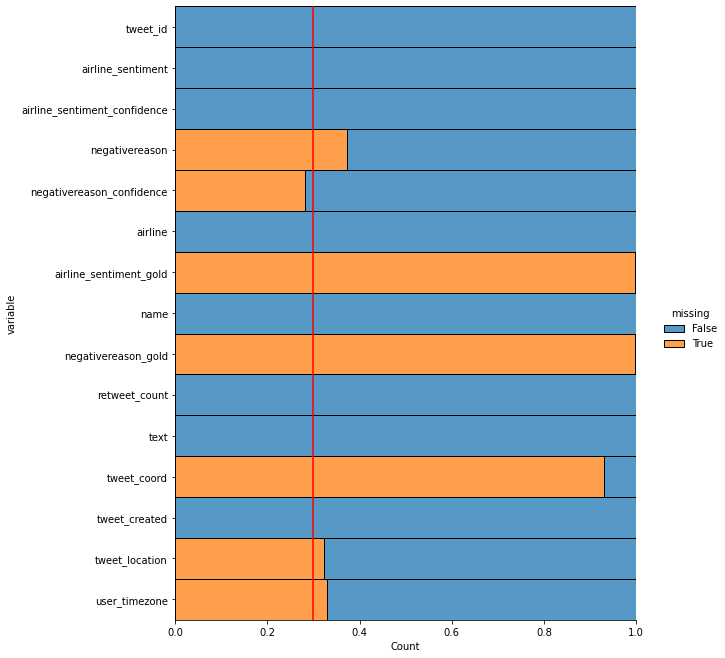

In [338]:
plt.figure(figsize=(4,6))
sns.displot(
    data=df.isnull().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    height=9.25
)
plt.axvline(0.3,color="r");

In [339]:
drop_columns = ['airline_sentiment_gold', 
                'negativereason_gold', 
                'tweet_coord'
                ]

In [340]:
df.drop(drop_columns, axis = 1, inplace = True)

In [341]:
df.shape

(14604, 12)

- Columns "negativereason_gold", "airline_sentiment_gold" and "tweet_coord" were dropped as they contain more than 90% missing values.

**Multicolinearity Check**

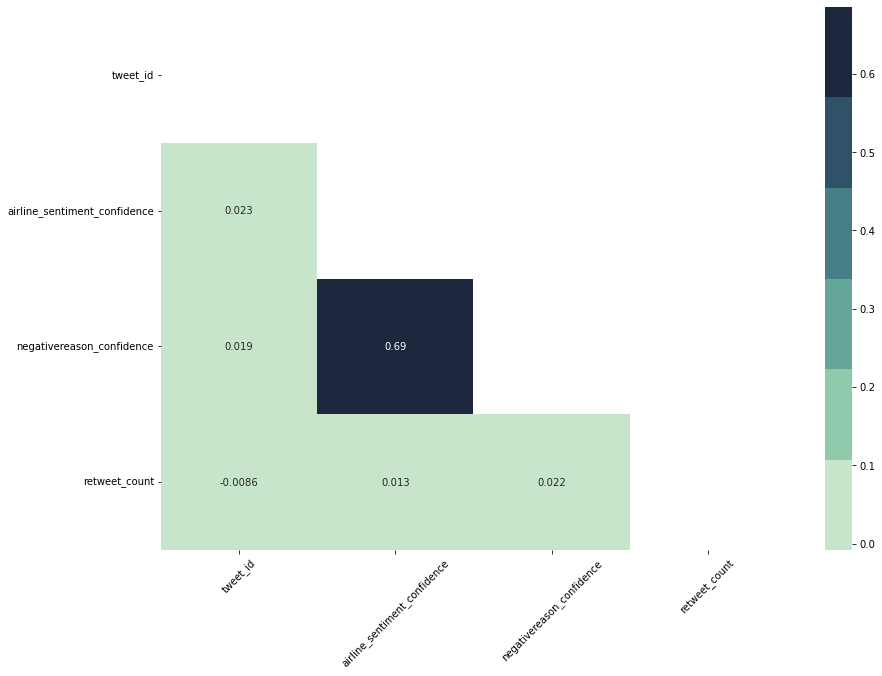

In [342]:
plt.figure(figsize = (14, 10))

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(df.corr())

# using the upper triangle matrix as mask 
sns.heatmap(df.corr(), annot = True, cmap = sns.cubehelix_palette(rot = -.4), mask = matrix)

plt.xticks(rotation = 45);

In [343]:
df_temp = df.corr()

count = "Done"
feature = []
collinear = []
for col in df_temp.columns:
    for i in df_temp.index:
        if (df_temp[col][i] > .9 and df_temp[col][i] < 1) or (df_temp[col][i] < -.9 and df_temp[col][i] > -1) :
                feature.append(col)
                collinear.append(i)
                print(Fore.RED + f"\033[1mmulticolinearity alert in between\033[0m {col} - {i}")
        else:
            print(f"For {col} and {i}, there is NO multicollinearity problem") 

print("\033[1mThe number of strong corelated features:\033[0m", count) 

For tweet_id and tweet_id, there is NO multicollinearity problem
For tweet_id and airline_sentiment_confidence, there is NO multicollinearity problem
For tweet_id and negativereason_confidence, there is NO multicollinearity problem
For tweet_id and retweet_count, there is NO multicollinearity problem
For airline_sentiment_confidence and tweet_id, there is NO multicollinearity problem
For airline_sentiment_confidence and airline_sentiment_confidence, there is NO multicollinearity problem
For airline_sentiment_confidence and negativereason_confidence, there is NO multicollinearity problem
For airline_sentiment_confidence and retweet_count, there is NO multicollinearity problem
For negativereason_confidence and tweet_id, there is NO multicollinearity problem
For negativereason_confidence and airline_sentiment_confidence, there is NO multicollinearity problem
For negativereason_confidence and negativereason_confidence, there is NO multicollinearity problem
For negativereason_confidence and

**The Examination of the related columns**

- In NLP we need to deal with the text and label columns.
- In the dataset, we will handle the "airline_sentiment" column as the "label" column and the "text" column as the "text" column.
- Let's continue to examine the remaining columns in order to increase our knowledge about the dataset.

In [344]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline', 'name',
       'retweet_count', 'text', 'tweet_created', 'tweet_location',
       'user_timezone'],
      dtype='object')

In [345]:
print(df.groupby('airline')['tweet_id'].count())

airline
American          2723
Delta             2222
Southwest         2420
US Airways        2913
United            3822
Virgin America     504
Name: tweet_id, dtype: int64


In [346]:
fig = px.histogram(df, x = 'airline', title = 'Tweet Counts by Airlines')
fig.show()

In [347]:
fig = px.pie(df, values = 'tweet_id', names = 'airline', title='Tweet Percentage by Airlines')
fig.show()

**airline_sentiment**

In [348]:
first_look('airline_sentiment')

column name    :  airline_sentiment
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  3
negative    9159
neutral     3091
positive    2354
Name: airline_sentiment, dtype: int64


In [349]:
fig = px.histogram(df, x = 'airline_sentiment', title = 'Airline Sentiments Distribution')
fig.show();

In [350]:
fig = px.pie(df, values = 'tweet_id', names = 'airline_sentiment', title='Airline Sentiment Distribution')
fig.show()

In [351]:
fig = px.histogram(df, x = 'airline', color = 'airline_sentiment', title = 'Airline Sentiments By Airlines')
fig.show();

**airline_sentiment_confidence**

In [352]:
first_look('airline_sentiment_confidence')

column name    :  airline_sentiment_confidence
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  1023
1.000    10409
0.667       71
0.663       35
0.660       30
0.656       30
         ...  
0.367        1
0.616        1
0.371        1
0.691        1
0.349        1
Name: airline_sentiment_confidence, Length: 1023, dtype: int64


In [353]:
print(df.groupby('airline')['airline_sentiment_confidence'].mean())

airline
American         0.916
Delta            0.870
Southwest        0.887
US Airways       0.922
United           0.901
Virgin America   0.876
Name: airline_sentiment_confidence, dtype: float64


In [354]:
fig = px.bar(df, x = df.groupby('airline')['airline_sentiment_confidence'].mean().index,
                 y = df.groupby('airline')['airline_sentiment_confidence'].mean().values,
                title = 'Airline Sentiment Confidence Values By Airlines (Mean)')
fig.show();

**negativereason**

In [355]:
first_look('negativereason')

column name    :  negativereason
--------------------------------
per_of_nulls   :  % 37.28
num_of_nulls   :  5445
num_of_uniques :  10
NaN                            5445
Customer Service Issue         2904
Late Flight                    1660
Can't Tell                     1190
Cancelled Flight                843
Lost Luggage                    721
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     480
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64


In [356]:
df['negativereason'].fillna('Null', inplace=True)

In [357]:
fig = px.histogram(df, x = 'negativereason', title = 'Negative Reason Distribution')
fig.show();

In [358]:
fig = px.pie(df, values = 'tweet_id', names = 'negativereason', title='Negative Reason Distribution')
fig.show()

In [359]:
px.histogram(df, x = 'airline', color = 'negativereason')

**negativereason_confidence**

In [360]:
first_look('negativereason_confidence')

column name    :  negativereason_confidence
--------------------------------
per_of_nulls   :  % 28.08
num_of_nulls   :  4101
num_of_uniques :  1410
NaN      4101
1.000    3417
0.000    1344
0.667      62
0.663      33
         ... 
0.610       1
0.372       1
0.703       1
0.388       1
0.726       1
Name: negativereason_confidence, Length: 1411, dtype: int64


In [361]:
print(df.groupby('airline')['negativereason_confidence'].mean())

airline
American         0.664
Delta            0.573
Southwest        0.602
US Airways       0.687
United           0.627
Virgin America   0.557
Name: negativereason_confidence, dtype: float64


In [362]:
fig = px.bar(df, x = df.groupby('airline')['negativereason_confidence'].mean().index,
                 y = df.groupby('airline')['negativereason_confidence'].mean().values,
                title = 'Negatif Reason Confidence Values By Airlines (Mean)')
fig.show();

# 2. Feature Selection and Data Cleaning

From now on, the DataFrame we will work with should contain two columns: **"text"** and **"airline_sentiment"**. 

In [363]:
df2 = df[['airline_sentiment','text']]
df2

airline_sentiment  \
0               neutral   
1              positive   
2               neutral   
3              negative   
4              negative   
...                 ...   
14635          positive   
14636          negative   
14637           neutral   
14638          negative   
14639           neutral   

                                                                                                                                                         text  
0                                                                                                                         @VirginAmerica What @dhepburn said.  
1                                                                                    @VirginAmerica plus you've added commercials to the experience... tacky.  
2                                                                                     @VirginAmerica I didn't today... Must mean I need to take another trip!  
3                              @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse  
4                                                                                                     @VirginAmerica and it's a really big bad thing about it  
...                                                                                                                                                       ...  
14635                                                                                         @AmericanAir thank you we got on a different flight to Chicago.  
14636  @AmericanAir leaving over 20 minutes Late Flight. No warnings or communication until we were 15 minutes Late Flight. That's called shitty customer svc  
14637                                                                                            @AmericanAir Please bring American Airlines to #BlackBerry10  
14638                 @AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??  
14639              @AmericanAir we have 8 ppl so we need 2 know how many seats are on the next flight. Plz put us on standby for 4 people on the next flight?  

[14604 rows x 2 columns]

In [364]:
df2['airline_sentiment'].value_counts()

negative    9159
neutral     3091
positive    2354
Name: airline_sentiment, dtype: int64

- Looking at the data of the airline_sentiment (label column) column, it is clearly seen that the dataset is IMBALANCED. 

In [365]:
missing_values (df2)

Empty DataFrame
Columns: [Missing_Number, Missing_Percent]
Index: []

In [366]:
print("There are", df2.duplicated(subset=None, keep='first').sum(), "duplicated observations in the dataset.")

There are 152 duplicated observations in the dataset.


### Cleaning Data

- When the "text" column is checked, it is seen that the "#" character and the airline name are written at the beginning of each text. We need to get rid of them. 
- In order to apply str.functions (functions in pandas), it is necessary to convert them into Series first. 

In [367]:
df2["text"].head()

0                                                                                               @VirginAmerica What @dhepburn said.
1                                                          @VirginAmerica plus you've added commercials to the experience... tacky.
2                                                           @VirginAmerica I didn't today... Must mean I need to take another trip!
3    @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
4                                                                           @VirginAmerica and it's a really big bad thing about it
Name: text, dtype: object

In [368]:
df2["text"] = df2["text"].apply(lambda x: pd.Series(x).str.replace("(@+\w+)", ""))
df2["text"].head()

0                                                                                                         What  said.
1                                                           plus you've added commercials to the experience... tacky.
2                                                            I didn't today... Must mean I need to take another trip!
3     it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
4                                                                            and it's a really big bad thing about it
Name: text, dtype: object

In [369]:
stop_words = stopwords.words('english')

In [370]:
def cleaning(data):
    
    #1. Tokenize
    text_tokens = word_tokenize(data.replace("'", "").lower()) 
        
    #2. Remove Puncs
    tokens_without_punc = [w for w in text_tokens if w.isalpha()]  
    
    #3. Removing Stopwords
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]  # stopword lerden temizleme  
    
    #4. lemma
    text_cleaned = [WordNetLemmatizer().lemmatize(t) for t in tokens_without_sw]
        
    #joining
    return " ".join(text_cleaned)

In [371]:
df2["text"] = df2["text"].apply(cleaning)
df2["text"].head()

0                                                                              said
1                                      plus youve added commercial experience tacky
2                                      didnt today must mean need take another trip
3    really aggressive blast obnoxious entertainment guest face amp little recourse
4                                                              really big bad thing
Name: text, dtype: object

### Removing Rare Words

In [372]:
" ".join(df2["text"]).split()

['said',
 'plus',
 'youve',
 'added',
 'commercial',
 'experience',
 'tacky',
 'didnt',
 'today',
 'must',
 'mean',
 'need',
 'take',
 'another',
 'trip',
 'really',
 'aggressive',
 'blast',
 'obnoxious',
 'entertainment',
 'guest',
 'face',
 'amp',
 'little',
 'recourse',
 'really',
 'big',
 'bad',
 'thing',
 'seriously',
 'would',
 'pay',
 'flight',
 'seat',
 'didnt',
 'playing',
 'really',
 'bad',
 'thing',
 'flying',
 'va',
 'yes',
 'nearly',
 'every',
 'time',
 'fly',
 'vx',
 'ear',
 'worm',
 'go',
 'away',
 'really',
 'missed',
 'prime',
 'opportunity',
 'men',
 'without',
 'hat',
 'parody',
 'http',
 'well',
 'amazing',
 'arrived',
 'hour',
 'early',
 'youre',
 'good',
 'know',
 'suicide',
 'second',
 'leading',
 'cause',
 'death',
 'among',
 'teen',
 'lt',
 'pretty',
 'graphic',
 'much',
 'better',
 'minimal',
 'iconography',
 'great',
 'deal',
 'already',
 'thinking',
 'trip',
 'amp',
 'havent',
 'even',
 'gone',
 'trip',
 'yet',
 'p',
 'im',
 'flying',
 'fabulous',
 'seductiv

In [373]:
rare_words = pd.Series(" ".join(df2["text"]).split()).value_counts()
rare_words

flight          4534
get             1374
http            1207
hour            1135
thanks          1073
                ... 
dynamite           1
unapologetic       1
uninformed         1
zipper             1
aire               1
Length: 9881, dtype: int64

In [374]:
rare_words = rare_words[rare_words <= 2] 

In [375]:
rare_words.index

Index(['digging', 'debating', 'qualifies', 'follower', 'ooh', 'emerald', 'ow',
       'betting', 'amsterdam', 'hd',
       ...
       'governor', 'gov', 'rnd', 'irate', 'quietly', 'dynamite',
       'unapologetic', 'uninformed', 'zipper', 'aire'],
      dtype='object', length=6162)

In [376]:
df2["text"] = df2["text"].apply(lambda x: " ".join([i for i in x.split() if i not in rare_words.index]))
df2["text"].head()

0                                                              said
1                            plus youve added commercial experience
2                      didnt today must mean need take another trip
3    really aggressive entertainment guest face amp little recourse
4                                              really big bad thing
Name: text, dtype: object

# 4. WordCloud - Repetition of Words

### Detect Reviews (positive, neutral and negative separately)

In [377]:
df2[df2["airline_sentiment"] == "positive"].head(3)

airline_sentiment                                    text
1          positive  plus youve added commercial experience
6          positive    yes nearly every time fly vx go away
8          positive                                    well

In [378]:
df2[df2["airline_sentiment"] == "neutral"].head(3)

airline_sentiment                                                  text
0           neutral                                                  said
2           neutral          didnt today must mean need take another trip
7           neutral  really missed prime opportunity men without hat http

In [379]:
df2[df2["airline_sentiment"] == "negative"].head(3)

airline_sentiment  \
3          negative   
4          negative   
5          negative   

                                                                       text  
3            really aggressive entertainment guest face amp little recourse  
4                                                      really big bad thing  
5  seriously would pay flight seat didnt playing really bad thing flying va

### Collect Words (positive, neutral and negative separately)

In [380]:
" ".join(df2["text"]).split()

['said',
 'plus',
 'youve',
 'added',
 'commercial',
 'experience',
 'didnt',
 'today',
 'must',
 'mean',
 'need',
 'take',
 'another',
 'trip',
 'really',
 'aggressive',
 'entertainment',
 'guest',
 'face',
 'amp',
 'little',
 'recourse',
 'really',
 'big',
 'bad',
 'thing',
 'seriously',
 'would',
 'pay',
 'flight',
 'seat',
 'didnt',
 'playing',
 'really',
 'bad',
 'thing',
 'flying',
 'va',
 'yes',
 'nearly',
 'every',
 'time',
 'fly',
 'vx',
 'go',
 'away',
 'really',
 'missed',
 'prime',
 'opportunity',
 'men',
 'without',
 'hat',
 'http',
 'well',
 'amazing',
 'arrived',
 'hour',
 'early',
 'youre',
 'good',
 'know',
 'suicide',
 'second',
 'leading',
 'cause',
 'death',
 'among',
 'teen',
 'lt',
 'pretty',
 'much',
 'better',
 'great',
 'deal',
 'already',
 'thinking',
 'trip',
 'amp',
 'havent',
 'even',
 'gone',
 'trip',
 'yet',
 'p',
 'im',
 'flying',
 'fabulous',
 'sky',
 'u',
 'take',
 'stress',
 'away',
 'travel',
 'http',
 'thanks',
 'schedule',
 'still',
 'mia',
 'excit

In [381]:
positive_words =" ".join(df2[df2["airline_sentiment"] == "positive"].text).split()
positive_words

['plus',
 'youve',
 'added',
 'commercial',
 'experience',
 'yes',
 'nearly',
 'every',
 'time',
 'fly',
 'vx',
 'go',
 'away',
 'well',
 'amazing',
 'arrived',
 'hour',
 'early',
 'youre',
 'good',
 'lt',
 'pretty',
 'much',
 'better',
 'great',
 'deal',
 'already',
 'thinking',
 'trip',
 'amp',
 'havent',
 'even',
 'gone',
 'trip',
 'yet',
 'p',
 'im',
 'flying',
 'fabulous',
 'sky',
 'u',
 'take',
 'stress',
 'away',
 'travel',
 'http',
 'thanks',
 'excited',
 'first',
 'cross',
 'country',
 'flight',
 'lax',
 'mco',
 'ive',
 'heard',
 'nothing',
 'great',
 'thing',
 'virgin',
 'america',
 'flying',
 'know',
 'would',
 'awesome',
 'please',
 'want',
 'fly',
 'love',
 'http',
 'love',
 'innovation',
 'feel',
 'good',
 'brand',
 'great',
 'news',
 'america',
 'could',
 'start',
 'flight',
 'hawaii',
 'end',
 'year',
 'http',
 'via',
 'way',
 'fly',
 'best',
 'experience',
 'ever',
 'cool',
 'done',
 'done',
 'best',
 'airline',
 'around',
 'hand',
 'view',
 'downtown',
 'sign',
 'beyo

In [382]:
neutral_words =" ".join(df2[df2["airline_sentiment"] == "neutral"].text).split()
neutral_words

['said',
 'didnt',
 'today',
 'must',
 'mean',
 'need',
 'take',
 'another',
 'trip',
 'really',
 'missed',
 'prime',
 'opportunity',
 'men',
 'without',
 'hat',
 'http',
 'know',
 'suicide',
 'second',
 'leading',
 'cause',
 'death',
 'among',
 'teen',
 'making',
 'bos',
 'gt',
 'la',
 'non',
 'stop',
 'anytime',
 'soon',
 'miss',
 'dont',
 'worry',
 'well',
 'together',
 'soon',
 'lax',
 'ewr',
 'middle',
 'seat',
 'red',
 'eye',
 'hour',
 'operation',
 'club',
 'sfo',
 'posted',
 'online',
 'current',
 'nice',
 'rt',
 'takeoff',
 'touchdown',
 'http',
 'book',
 'flight',
 'hawaii',
 'plz',
 'help',
 'win',
 'upgrade',
 'flight',
 'lax',
 'gt',
 'sea',
 'unused',
 'ticket',
 'moved',
 'new',
 'city',
 'dont',
 'fly',
 'fly',
 'expires',
 'flight',
 'leaving',
 'dallas',
 'seattle',
 'time',
 'feb',
 'dream',
 'http',
 'http',
 'last',
 'night',
 'think',
 'agree',
 'entertaining',
 'flight',
 'way',
 'supposed',
 'take',
 'minute',
 'ago',
 'website',
 'still',
 'show',
 'time',
 'fl

In [383]:
negative_words =" ".join(df2[df2["airline_sentiment"] == "negative"].text).split()
negative_words

['really',
 'aggressive',
 'entertainment',
 'guest',
 'face',
 'amp',
 'little',
 'recourse',
 'really',
 'big',
 'bad',
 'thing',
 'seriously',
 'would',
 'pay',
 'flight',
 'seat',
 'didnt',
 'playing',
 'really',
 'bad',
 'thing',
 'flying',
 'va',
 'schedule',
 'still',
 'mia',
 'flew',
 'nyc',
 'sfo',
 'last',
 'week',
 'couldnt',
 'fully',
 'sit',
 'seat',
 'due',
 'two',
 'large',
 'either',
 'side',
 'help',
 'first',
 'fare',
 'may',
 'three',
 'time',
 'carrier',
 'seat',
 'available',
 'select',
 'guy',
 'messed',
 'seating',
 'reserved',
 'seating',
 'friend',
 'guy',
 'gave',
 'seat',
 'away',
 'want',
 'free',
 'internet',
 'status',
 'match',
 'program',
 'applied',
 'three',
 'week',
 'called',
 'emailed',
 'response',
 'happened',
 'ur',
 'vegan',
 'food',
 'option',
 'least',
 'say',
 'ur',
 'site',
 'know',
 'wont',
 'able',
 'eat',
 'anything',
 'next',
 'hr',
 'fail',
 'amazing',
 'cant',
 'get',
 'cold',
 'air',
 'worstflightever',
 'roasted',
 'hi',
 'cool',
 'b

In [384]:
len(positive_words)

15709

In [385]:
len(neutral_words)

20065

In [386]:
len(negative_words)

84571

### Create Word Cloud (for most common words in airline_sentiment reviews separately)

In [387]:
review_text = df2["text"]
all_words = " ".join(review_text)
all_words[:100]

'said plus youve added commercial experience didnt today must mean need take another trip really aggr'

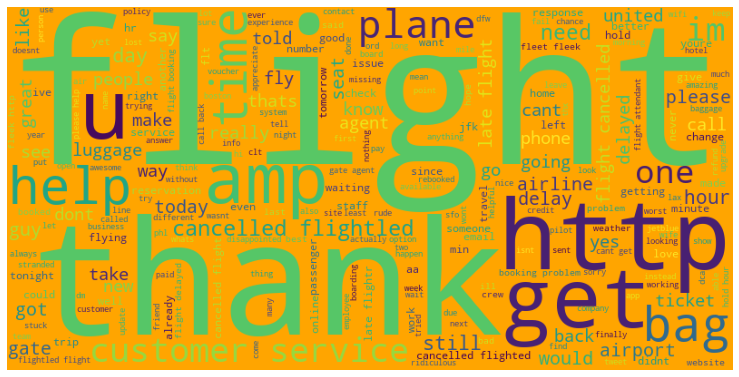

In [388]:
wc = WordCloud(stopwords=stop_words, 
               background_color="orange", 
               max_words=250, 
               max_font_size=256, 
               random_state=42,
               width=800, height=400)
wc.generate(all_words)
plt.figure(figsize = (13, 13))
plt.imshow(wc)
plt.axis('off')
plt.show()

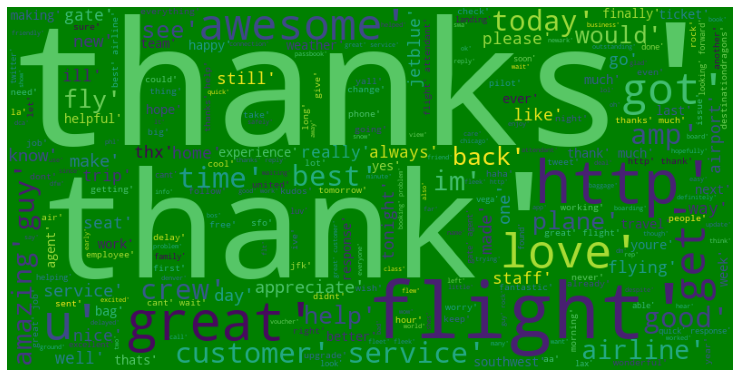

In [389]:
wc = WordCloud(stopwords=stop_words, 
               background_color="green", 
               max_words=250, 
               max_font_size=256, 
               random_state=42,
               width=800, height=400)
wc.generate(str(positive_words))
plt.figure(figsize = (13, 13))
plt.imshow(wc)
plt.axis('off')
plt.show()

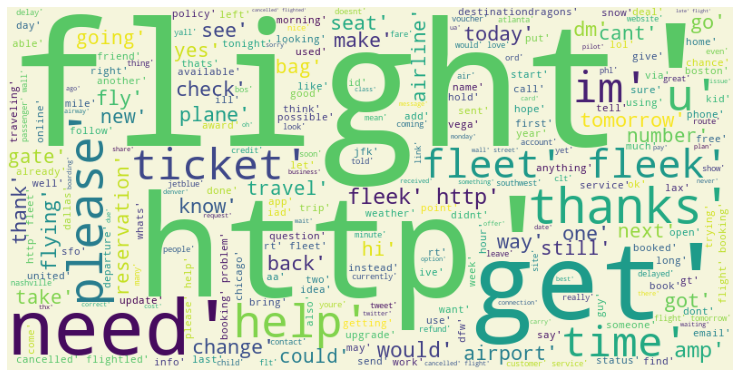

In [390]:
wc = WordCloud(stopwords=stop_words, 
               background_color="beige", 
               max_words=250, 
               max_font_size=256, 
               random_state=42,
               width=800, height=400)
wc.generate(str(neutral_words))
plt.figure(figsize = (13, 13))
plt.imshow(wc)
plt.axis('off')
plt.show()

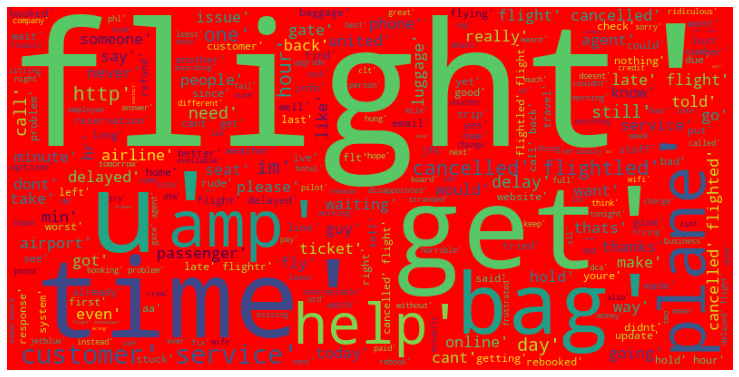

In [391]:
wc = WordCloud(stopwords=stop_words, 
               background_color="red", 
               max_words=250, 
               max_font_size=256, 
               random_state=42,
               width=800, height=400)
wc.generate(str(negative_words))
plt.figure(figsize = (13, 13))
plt.imshow(wc)
plt.axis('off')
plt.show()

### Counting words

In [392]:
counter_all = Counter(word_tokenize(all_words))
counter_all.most_common(50)

[('flight', 4534),
 ('get', 1374),
 ('http', 1207),
 ('hour', 1135),
 ('thanks', 1073),
 ('cancelled', 1050),
 ('u', 993),
 ('service', 987),
 ('time', 944),
 ('customer', 932),
 ('help', 868),
 ('bag', 761),
 ('im', 741),
 ('plane', 722),
 ('amp', 683),
 ('hold', 639),
 ('need', 632),
 ('thank', 601),
 ('still', 580),
 ('one', 579),
 ('cant', 577),
 ('please', 562),
 ('call', 560),
 ('airline', 553),
 ('would', 548),
 ('day', 547),
 ('gate', 540),
 ('delayed', 534),
 ('back', 524),
 ('flightled', 502),
 ('dont', 490),
 ('seat', 480),
 ('got', 478),
 ('phone', 452),
 ('delay', 438),
 ('like', 431),
 ('today', 427),
 ('late', 425),
 ('guy', 421),
 ('agent', 414),
 ('know', 380),
 ('ticket', 380),
 ('fly', 378),
 ('make', 375),
 ('waiting', 368),
 ('airport', 366),
 ('change', 360),
 ('way', 355),
 ('trying', 348),
 ('minute', 344)]

# 5. Sentiment Classification with Machine Learning and Deep Learning

### Train - Test Split

In [393]:
X = df2["text"].values
y = df2["airline_sentiment"].values

In [394]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 101)

In [395]:
X_train

array(['thank', 'finally hung hour able get flight needed',
       'biz trvl con flt next one missed food voucher hotel flt wifi hotel',
       ...,
       'traveling infant check carseat free provide bag someone told wanted confirm',
       'flight ha one employee said another said left want warm weather',
       'sure thank'], dtype=object)

In [396]:
X_test

array(['ive got visit hour im still wearing clothes',
       'thank appreciate response', 'thank', ...,
       'add insult injury go pick real class act ill stick delta',
       'get rr credit card get point family way',
       'every time check bag airline im confident wearing clothes day please prove wrong'],
      dtype=object)

### Count Vectorization

In [397]:
from sklearn.feature_extraction.text import CountVectorizer

In [398]:
vectorizer = CountVectorizer()

X_train_count = vectorizer.fit_transform(X_train)
X_test_count = vectorizer.transform(X_test)

In [399]:
X_train_count

<11683x3692 sparse matrix of type '<class 'numpy.int64'>'
	with 92335 stored elements in Compressed Sparse Row format>

In [400]:
X_train_count.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [401]:
len(X_train_count.toarray())

11683

In [402]:
X_test_count

<2921x3692 sparse matrix of type '<class 'numpy.int64'>'
	with 23167 stored elements in Compressed Sparse Row format>

In [403]:
X_test_count.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [404]:
len(X_test_count.toarray())

2921

In [405]:
pd.set_option('display.max_columns', 50)

In [406]:
pd.DataFrame(X_train_count.toarray(), columns = vectorizer.get_feature_names())

aa  aadvantage  abc  ability  able  aboard  abq  absolute  absolutely  \
0       0           0    0        0     0       0    0         0           0   
1       0           0    0        0     1       0    0         0           0   
2       0           0    0        0     0       0    0         0           0   
3       0           0    0        0     0       0    0         0           0   
4       0           0    0        0     0       0    0         0           0   
...    ..         ...  ...      ...   ...     ...  ...       ...         ...   
11678   0           0    0        0     0       0    0         0           0   
11679   0           0    0        0     0       0    0         0           0   
11680   0           0    0        0     0       0    0         0           0   
11681   0           0    0        0     0       0    0         0           0   
11682   0           0    0        0     0       0    0         0           0   

       absurd  abt  abysmal  ac  accept  acceptable  accepted  accepting  \
0           0    0        0   0       0           0         0          0   
1           0    0        0   0       0           0         0          0   
2           0    0        0   0       0           0         0          0   
3           0    0        0   0       0           0         0          0   
4           0    0        0   0       0           0         0          0   
...       ...  ...      ...  ..     ...         ...       ...        ...   
11678       0    0        0   0       0           0         0          0   
11679       0    0        0   0       0           0         0          0   
11680       0    0        0   0       0           0         0          0   
11681       0    0        0   0       0           0         0          0   
11682       0    0        0   0       0           0         0          0   

       access  accident  accidentally  accommodate  accommodating  \
0           0         0             0            0              0   
1           0         0             0            0              0   
2           0         0             0            0              0   
3           0         0             0            0              0   
4           0         0             0            0              0   
...       ...       ...           ...          ...            ...   
11678       0         0             0            0              0   
11679       0         0             0            0              0   
11680       0         0             0            0              0   
11681       0         0             0            0              0   
11682       0         0             0            0              0   

       accommodation  accomplished  according  ...  yell  yelled  yelling  \
0                  0             0          0  ...     0       0        0   
1                  0             0          0  ...     0       0        0   
2                  0             0          0  ...     0       0        0   
3                  0             0          0  ...     0       0        0   
4                  0             0          0  ...     0       0        0   
...              ...           ...        ...  ...   ...     ...      ...   
11678              0             0          0  ...     0       0        0   
11679              0             0          0  ...     0       0        0   
11680              0             0          0  ...     0       0        0   
11681              0             0          0  ...     0       0        0   
11682              0             0          0  ...     0       0        0   

       yep  yes  yest  yesterday  yet  yo  york  youd  youll  young  youre  \
0        0    0     0          0    0   0     0     0      0      0      0   
1        0    0     0          0    0   0     0     0      0      0      0   
2        0    0     0          0    0   0     0     0      0      0      0   
3        0    0     0          0    0   0     0     0      0      0

In [407]:
X_train[6]

'thats cool'

In [408]:
vectorizer.vocabulary_

{'thank': 3261,
 'finally': 1240,
 'hung': 1609,
 'hour': 1590,
 'able': 4,
 'get': 1387,
 'flight': 1266,
 'needed': 2145,
 'biz': 350,
 'trvl': 3388,
 'con': 673,
 'flt': 1284,
 'next': 2163,
 'one': 2248,
 'missed': 2085,
 'food': 1301,
 'voucher': 3535,
 'hotel': 1587,
 'wifi': 3603,
 'sitting': 2992,
 'runway': 2816,
 'leave': 1854,
 'airport': 81,
 'luggage': 1960,
 'ur': 3480,
 'day': 832,
 'rebooked': 2629,
 'isnt': 1735,
 'monday': 2098,
 'dont': 982,
 'never': 2155,
 'airway': 82,
 'professional': 2529,
 'despite': 896,
 'challenge': 523,
 'made': 1968,
 'passenger': 2342,
 'feel': 1216,
 'like': 1879,
 'priority': 2516,
 'thats': 3268,
 'cool': 730,
 'departing': 877,
 'http': 1599,
 'ticket': 3300,
 'counter': 748,
 'people': 2372,
 'helping': 1528,
 'want': 3551,
 'charge': 532,
 'money': 2099,
 'even': 1106,
 'horrible': 1579,
 'unfortunately': 3441,
 'lack': 1824,
 'status': 3109,
 'big': 337,
 'problem': 2523,
 'company': 652,
 'policy': 2453,
 'force': 1303,
 'buy': 44

## TF-IDF

sklearn TD-IDF
https://towardsdatascience.com/how-sklearns-tf-idf-is-different-from-the-standard-tf-idf-275fa582e73d

In [90]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [91]:
tf_idf_vectorizer = TfidfVectorizer()
X_train_tf_idf = tf_idf_vectorizer.fit_transform(X_train)
X_test_tf_idf = tf_idf_vectorizer.transform(X_test)

# fit burada tüm tokenleri sayıyor. sonra da teker teker öncelikle TF fonksiyonunu uyguluyor. 
#  sonra IDF bulmak için bu kelimeler tüm dokümanlarda geçmiş mi geçmemiş mi onları sayıyor. 
# transform deyince de TF-IDF katsayısını hesaplayıp buluyor.

In [93]:
tf_idf_vectorizer.get_feature_names()

['another',
 'away',
 'bad',
 'big',
 'dhepburn',
 'ear',
 'every',
 'fly',
 'go',
 'mean',
 'must',
 'nearly',
 'need',
 'really',
 'said',
 'take',
 'thing',
 'time',
 'today',
 'trip',
 'virginamerica',
 'vx',
 'worm',
 'yes']

In [94]:
X_train_tf_idf.toarray()

array([[0.        , 0.31200802, 0.        , 0.        , 0.        ,
        0.31200802, 0.31200802, 0.31200802, 0.31200802, 0.        ,
        0.        , 0.31200802, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.31200802, 0.        , 0.        ,
        0.16281873, 0.31200802, 0.31200802, 0.31200802],
       [0.        , 0.        , 0.        , 0.        , 0.66338461,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.66338461,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.34618161, 0.        , 0.        , 0.        ],
       [0.37082034, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.37082034,
        0.37082034, 0.        , 0.37082034, 0.        , 0.        ,
        0.37082034, 0.        , 0.        , 0.37082034, 0.37082034,
        0.19350944, 0.        , 0.        , 0.        ],
       [0.   

In [95]:
pd.DataFrame(X_train_tf_idf.toarray(), columns = tf_idf_vectorizer.get_feature_names())

another      away       bad       big  dhepburn       ear     every  \
0  0.00000  0.312008  0.000000  0.000000  0.000000  0.312008  0.312008   
1  0.00000  0.000000  0.000000  0.000000  0.663385  0.000000  0.000000   
2  0.37082  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3  0.00000  0.000000  0.483803  0.483803  0.000000  0.000000  0.000000   

        fly        go     mean     must    nearly     need    really  \
0  0.312008  0.312008  0.00000  0.00000  0.312008  0.00000  0.000000   
1  0.000000  0.000000  0.00000  0.00000  0.000000  0.00000  0.000000   
2  0.000000  0.000000  0.37082  0.37082  0.000000  0.37082  0.000000   
3  0.000000  0.000000  0.00000  0.00000  0.000000  0.00000  0.483803   

       said     take     thing      time    today     trip  virginamerica  \
0  0.000000  0.00000  0.000000  0.312008  0.00000  0.00000       0.162819   
1  0.663385  0.00000  0.000000  0.000000  0.00000  0.00000       0.346182   
2  0.000000  0.37082  0.000000  0.000000  0.37082  0.37082       0.193509   
3  0.000000  0.00000  0.483803  0.000000  0.00000  0.00000       0.252468   

         vx      worm       yes  
0  0.312008  0.312008  0.312008  
1  0.000000  0.000000  0.000000  
2  0.000000  0.000000  0.000000  
3  0.000000  0.000000  0.000000

In [96]:
X_train[6]

'virginamerica yes nearly every time fly vx ear worm go away'

In [99]:
pd.DataFrame(X_train_tf_idf.toarray(), columns = tf_idf_vectorizer.get_feature_names()).loc[1].sort_values(ascending=False)

# virginamerica tüm dokümanlarda geçtiği için doğal olarak onun ağırlığını azaltmış. en hafifi o olmuş.

dhepburn         0.663385
said             0.663385
virginamerica    0.346182
another          0.000000
really           0.000000
worm             0.000000
vx               0.000000
trip             0.000000
today            0.000000
time             0.000000
thing            0.000000
take             0.000000
need             0.000000
away             0.000000
nearly           0.000000
must             0.000000
mean             0.000000
go               0.000000
fly              0.000000
every            0.000000
ear              0.000000
big              0.000000
bad              0.000000
yes              0.000000
Name: 1, dtype: float64

In [100]:
pd.DataFrame(X_train_tf_idf.toarray(), columns = tf_idf_vectorizer.get_feature_names()).loc[0].sort_values(ascending=False)

# loc[0] da da virginamerica nın en düşük ağırlığa sahip olduğunu görüyoruz. 

yes              0.312008
worm             0.312008
vx               0.312008
ear              0.312008
every            0.312008
fly              0.312008
go               0.312008
nearly           0.312008
away             0.312008
time             0.312008
virginamerica    0.162819
take             0.000000
trip             0.000000
today            0.000000
thing            0.000000
another          0.000000
said             0.000000
really           0.000000
must             0.000000
mean             0.000000
dhepburn         0.000000
big              0.000000
bad              0.000000
need             0.000000
Name: 0, dtype: float64